# YouTube on Android

The goal of this experiment is to run Youtube videos on a Pixel device running Android and collect results.

In [1]:
from conf import LisaLogging
import logging
LisaLogging.setup(level=logging.DEBUG)

2017-09-11 05:33:34,472 INFO    : root         : Using LISA logging configuration:
2017-09-11 05:33:34,473 INFO    : root         :   /home/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import System, Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')

    # Get workload
    wload = Workload(te).getInstance(te, 'YouTube')
    
    # Run Youtube workload
    wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
              video_duration_s=5, collect='ftrace')

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },


    # Folder where all the results will be collected
    "results_dir" : "Youtube_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
             
            # Add here the events you wanna enable by hand
            "sched_energy_diff",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset' ],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf)
target = te.target

2017-09-11 05:33:39,036 INFO    : TestEnv      : Using base path: /home/lisa/lisa-github
2017-09-11 05:33:39,038 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-09-11 05:33:39,039 WARNING : TestEnv      : Wipe previous contents of the results folder:
2017-09-11 05:33:39,041 WARNING : TestEnv      :    /home/lisa/lisa-github/results/Youtube_example
2017-09-11 05:33:39,056 INFO    : TestEnv      : External tools using:
2017-09-11 05:33:39,057 INFO    : TestEnv      :    ANDROID_HOME: /home/lisa/android-sdk
2017-09-11 05:33:39,058 INFO    : TestEnv      :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
2017-09-11 05:33:39,059 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-09-11 05:33:39,060 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-09-11 05:33:39,061 INFO    : TestEnv      : Connection settings:
2017-09-11 05:33:39,062 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-09-1

In [6]:
# ADB ROOT is requried for systrace to be able to get the generated trace from the target
!adb root

adbd is already running as root


## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Youtube** experiment.

In [7]:
# Intialize Workloads for this test environment
results = experiment()

2017-09-11 05:33:44,218 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.antutu.benchmark.full', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.android.dreams.basic', 'com.android.webview', 'com.android.inp

2017-09-11 05:33:59,715 DEBUG   : FtraceCollector : Trace CPUFreq frequencies
2017-09-11 05:33:59,877 INFO    : YouTube      : FTrace STOP
2017-09-11 05:34:02,418 INFO    : System       : am force-stop com.paraphron.youtube
2017-09-11 05:34:03,025 INFO    : Screen       : Set orientation: AUTO
2017-09-11 05:34:03,835 INFO    : Screen       : Set brightness: AUTO


## Benchmarks results

In [8]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 1675092718494ns
Total frames rendered: 395
Janky frames: 18 (4.56%)
50th percentile: 5ms
90th percentile: 12ms
95th percentile: 15ms
99th percentile: 38ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [9]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-09-11 05:34:04,037 DEBUG   : Trace        : Loading [sched] events from trace in [/home/lisa/lisa-github/results/Youtube_example/trace.dat]...
2017-09-11 05:34:04,039 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_wakeup_new', 'sched_overutilized', 'sched_load_avg_cpu', 'sched_load_avg_task', 'cpu_capacity', 'cpu_frequency', 'sched_energy_diff', 'cpu_frequency_devlib']
2017-09-11 05:34:04,041 DEBUG   : Trace        : Parsing FTrace format...
2017-09-11 05:34:17,581 DEBUG   : Trace        : Events found on trace:
2017-09-11 05:34:17,582 DEBUG   : Trace        :  - sched_load_avg_task
2017-09-11 05:34:17,583 DEBUG   : Trace        :  - cpu_frequency
2017-09-11 05:34:17,584 DEBUG   : Trace        :  - cpu_capacity
2017-09-11 05:34:17,585 DEBUG   : Trace        :  - sched_load_avg_cpu
2017-09-11 05:34:17,586 DEBUG   : Trace        :  - sched_wakeup_new
2017-09-11 05:34:17,587 DEBUG   : Trace        :  - cpu_frequency_devlib
2017-09-11 05:34:17,588 DEB

2017-09-11 05:34:18,008 DEBUG   : Analysis     : Filename: status_analysis
2017-09-11 05:34:18,009 DEBUG   : Analysis     : Parsing big.LITTLE system clusters
2017-09-11 05:34:18,010 DEBUG   : Trace        : Registering [<status_analysis.StatusAnalysis object at 0x7f8d11887210>] local data frames
2017-09-11 05:34:18,012 DEBUG   : Trace        :    overutilized
2017-09-11 05:34:18,013 DEBUG   : Trace        :    trace_event
2017-09-11 05:34:18,014 DEBUG   : Analysis     :    status
2017-09-11 05:34:18,015 DEBUG   : Analysis     : Filename: tasks_analysis
2017-09-11 05:34:18,016 DEBUG   : Analysis     : Parsing big.LITTLE system clusters
2017-09-11 05:34:18,017 DEBUG   : Trace        : Registering [<tasks_analysis.TasksAnalysis object at 0x7f8d096529d0>] local data frames
2017-09-11 05:34:18,018 DEBUG   : Trace        :    rt_tasks
2017-09-11 05:34:18,019 DEBUG   : Trace        :    top_big_tasks
2017-09-11 05:34:18,020 DEBUG   : Trace        :    top_wakeup_tasks
2017-09-11 05:34:18,021

2017-09-11 05:34:26,851 INFO    : Analysis     : LITTLE cluster average frequency: 1.467 GHz
2017-09-11 05:34:26,853 INFO    : Analysis     : big    cluster average frequency: 1.392 GHz
2017-09-11 05:34:26,854 INFO    : root         : Plotting cluster frequencies for [sched]...


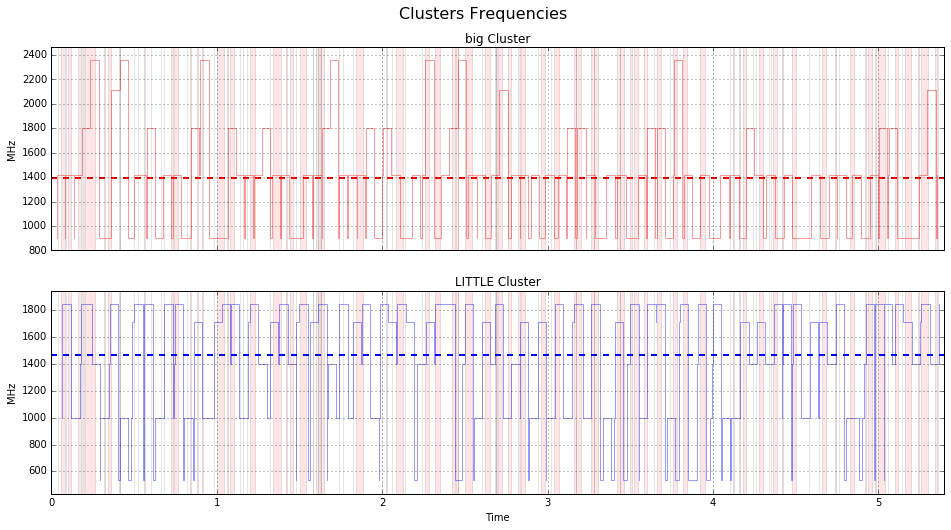

In [10]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

In [11]:
df = trace.data_frame.trace_event('sched_energy_diff')

In [ ]:
df.head()